In [1]:
from preprocessing import *
from clustering import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from GMM import my_GMM_uniform_cluster
data_contrats = pd.read_csv('train_contrats_approx.csv',sep=";")
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,5]

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def preprocessing(data, balance=True, train_size=0.5):
    import pandas as pd
    if balance : 
      data_non_nul=data[data.nombre_de_sinistre>0]
      data_nul=data[data.nombre_de_sinistre==0]
      data_nul_1,data_nul_2=train_test_split(data_nul,train_size=len(data_non_nul)/len(data_nul))
      data_clustering=pd.concat([data_non_nul,data_nul_1])
    else :
      data_clustering = data.copy()
    columns_conduc=["Classe_Age_Situ_Cont","Type_Apporteur","Activite"]
    columns_contrat=["Mode_gestion","Zone","Fractionnement","franchise","FORMULE",'Exposition_au_risque']
    #columns_vehi=["Age_du_vehicule","ValeurPuissance","Freq_sinistre"]
    columns_vehi=["Age_du_vehicule","ValeurPuissance"]
    data_clustering=data_clustering[columns_conduc+columns_contrat+columns_vehi]
    data_clustering.loc[:,"Classe_Age_Situ_Cont"]=data_clustering["Classe_Age_Situ_Cont"].apply(classe_age)
    data_clustering.loc[:,"franchise"]=data_clustering["franchise"].apply(franchise_)
    data_clustering.loc[:,["Type_Apporteur","Activite","Zone","FORMULE"]] = data_clustering[["Type_Apporteur","Activite","Zone","FORMULE"]].astype('str')
    data_clustering_d=pd.get_dummies(data_clustering)
    #data_scaled = normalize(data_clustering_d, axis=0) 
    data_scaled = data_clustering_d

    data_scaled = pd.DataFrame(data_scaled, columns=data_clustering_d.columns)
    #data_scaled["Freq_sinistre"] = data["Freq_sinistre"]

    if train_size < 1 :
        train_data,test_data = train_test_split(data_scaled,train_size=train_size)
    else :
        train_data,test_data = data_scaled, None
    return train_data,test_data

Le but est ici d'évaluer la stabilité de differentes méthodes de clustering, en utilisant le procédé suivant : 
Clustering sur un jeu d'entrainement (75%) (Clustering A)
Nouveau clustering sur toute la base de données, ie 75% initaux + 25% restants (Clustering B)
Calcul du adjusted rand index, qui est d'autant plus grand que deux points dans un même cluster dan le clustering A sont toutjours dans le même cluster dans le clustering B, ou que deux points dans deux clusters différents dans le clustering A sont toutjours dans deux clusters différents dans le clustering B.
Lors du calcul du score, seuls 75% des points sont donc considérés.
Selon nous, une perturbation de 25% est forte, et permettera de vraiment mettre les méthodes de clustering à l'épreuve.

In [141]:
data = pd.read_csv("train_contrats_approx.csv", sep=";", engine="python")

# For original database ---
#data = pd.read_csv("train_contrats.csv", sep=";")
#data["Freq_sinistre"] = data["nombre_de_sinistre"]/data["Exposition_au_risque"]

data = preprocessing(data, balance=False, train_size=1.)[0]
train_data = data[:(int(len(data)*0.75))]

In [90]:
data

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,...,Zone_6,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans
0,6,3,0.55,7,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
1,5,2,0.41,7,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,5,2,0.23,7,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,5,2,0.26,4,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,6,2,0.24,4,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87223,6,2,0.28,7,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
87224,6,2,0.28,7,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
87225,6,2,0.16,7,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
87226,6,2,0.28,7,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


#### Adjusted rand index

Pour avoir une baseline et mieux intepreter l'ARI, il est calculé ici pour un clustering **aléatoire**, pour un nombre de point à peu près égal à celui de notre base de données. L'ARI devrait dans ce cas valoir 0.

In [0]:
ari = 0
for i in range(100):
  clust_A = np.random.randint(low=0, high=4, size=65000)
  clust_B = np.random.randint(low=0, high=4, size=65000)
  ari += adjusted_rand_score(clust_A,clust_B)/100

In [0]:
print(ari)

9.029652763787604e-07


### GMM clustering

Let's try with 5 clusters at first.

Train data

In [0]:
t= time.time()
estimator = GaussianMixture(n_components=5,
              covariance_type='full', max_iter=500, random_state=0)
GMM_labels_train=estimator.fit_predict(train_data.drop(["Freq_sinistre"],axis=1))
elapsed = time.time()-t
print("time elapsed : {} s".format(elapsed))

time elapsed : 6.481006860733032 s


In [0]:
Counter(GMM_labels_train)

Counter({0: 1108, 1: 41060, 2: 8147, 3: 6406, 4: 8700})

All data

In [0]:
t= time.time()
estimator = GaussianMixture(n_components=5,
              covariance_type='full', max_iter=500, random_state=0)
GMM_labels_all=estimator.fit_predict(data.drop(["Freq_sinistre"],axis=1))
elapsed = time.time()-t
print("time elapsed : {} s".format(elapsed))

time elapsed : 7.044588088989258 s


We select the point of train_data for comparison

In [0]:
GMM_labels_all = GMM_labels_all[:len(GMM_labels_train)]
adjusted_rand_score(GMM_labels_train,GMM_labels_all)

0.2477805078878556

Une ARI de 0.25 est basse. Le clustering par GMM semble peu fiable. Nous allons essayer de calculer cette valeur pour différent nombres de clusters.

Attention la cellule suivante nécessite 30mn-1h pour s'executer

In [163]:
ari=[]
dbs = []

from sklearn.metrics import davies_bouldin_score

for n_clusters in range(1,10):
          
    ari_i = []
    dbs_i = []
    
    for i in range(20):
      
        estimator_train = GaussianMixture(n_components=n_clusters)
        #GMM_labels_train=estimator_train.fit_predict(train_data.drop(["Freq_sinistre"],axis=1))
        GMM_labels_train=estimator_train.fit_predict(train_data)

        estimator = GaussianMixture(n_components=n_clusters)
        #GMM_labels_all=estimator.fit_predict(data.drop(["Freq_sinistre"],axis=1))
        GMM_labels_all=estimator.fit_predict(data)

        GMM_labels_all_ = GMM_labels_all[:len(GMM_labels_train)]
        ari_i.append(adjusted_rand_score(GMM_labels_train,GMM_labels_all_)) 
        
        if n_clusters> 1:
            dbs_i.append( davies_bouldin_score(data, GMM_labels_all))   
            
    print(f"{n_clusters} clusters : ARI = {np.mean(ari_i)}")
    ari.append(ari_i)
    dbs.append(dbs_i)

1 clusters : ARI = 1.0
2 clusters : ARI = 0.8043607956788292
3 clusters : ARI = 0.2820294841892269
4 clusters : ARI = 0.9559266563922421
5 clusters : ARI = 0.26284198113499474
6 clusters : ARI = 0.25579394672253714
7 clusters : ARI = 0.2814961192146281
8 clusters : ARI = 0.24231810055460948
9 clusters : ARI = 0.2527948612964741


In [170]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,5]

Text(0, 0.5, 'ARI')

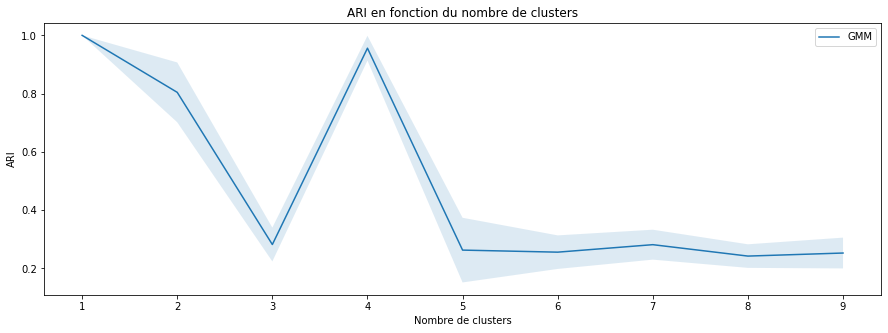

In [171]:
data_ari = np.array(ari)
T, n_rep = data_ari.shape
mean_ari = np.mean(data_ari, axis=1)
std_ari = np.std(data_ari, axis=1) / np.sqrt(n_rep)
t = np.arange(1,T+1)
plt.plot(t, mean_ari, label="GMM")
plt.fill_between(t, mean_ari - 2 * std_ari, mean_ari + 2 * std_ari, alpha=0.15)
plt.legend()
plt.title("ARI en fonction du nombre de clusters - GMM")
plt.xlabel("Nombre de clusters")
plt.ylabel("ARI")

4 cluster maximise le ARI

#### Profil moyen de chaque cluster

In [176]:
n_clusters = 4

estimator = GaussianMixture(n_components=n_clusters)
#GMM_labels_all=estimator.fit_predict(data.drop(["Freq_sinistre"],axis=1))
GMM_labels_all=estimator.fit_predict(data)

In [181]:
data["cluster"] = GMM_labels_all
count = Counter(GMM_labels_all)
#print(count)
data_group = data.groupby('cluster').mean()
data_group

,Classe_Age_Situ_Cont,franchise,Exposition_au_risque,ValeurPuissance,Type_Apporteur_1,Type_Apporteur_2,Type_Apporteur_3,Activite_1,Activite_2,Activite_3,...,Zone_6,Fractionnement_A,Fractionnement_S,Fractionnement_T,FORMULE_2,FORMULE_3,FORMULE_4,FORMULE_5,Age_du_vehicule_<= 5 ans,Age_du_vehicule_> 5 ans
cluster,,,,,,,,,,,,,,,,,,,,,
0,3.823377,2.247124,0.466716,5.116883,0.861224,0.120594,0.018182,0.008534,0.956957,0.010761,...,0.000371,0.795547,0.085343,0.119109,0.000000,0.785529,0.033766,0.180705,0.646011,0.353989
1,3.214223,3.040014,0.540119,6.186257,0.424136,0.267068,0.308796,0.289793,0.000000,0.240131,...,0.000000,0.284308,0.312567,0.403125,0.000000,0.580419,0.308796,0.110785,0.741111,0.258889
2,3.399419,2.975309,0.516558,5.949165,0.461147,0.308642,0.230211,0.189542,0.169935,0.134350,...,0.647059,0.290487,0.239651,0.469862,0.023965,0.631082,0.230211,0.114742,0.695715,0.304285
3,3.616676,2.747203,0.407106,6.297842,0.802050,0.197950,0.000000,0.230036,0.000000,0.177883,...,0.000000,0.323584,0.225764,0.450652,0.000000,0.851127,0.000000,0.148873,0.647725,0.352275


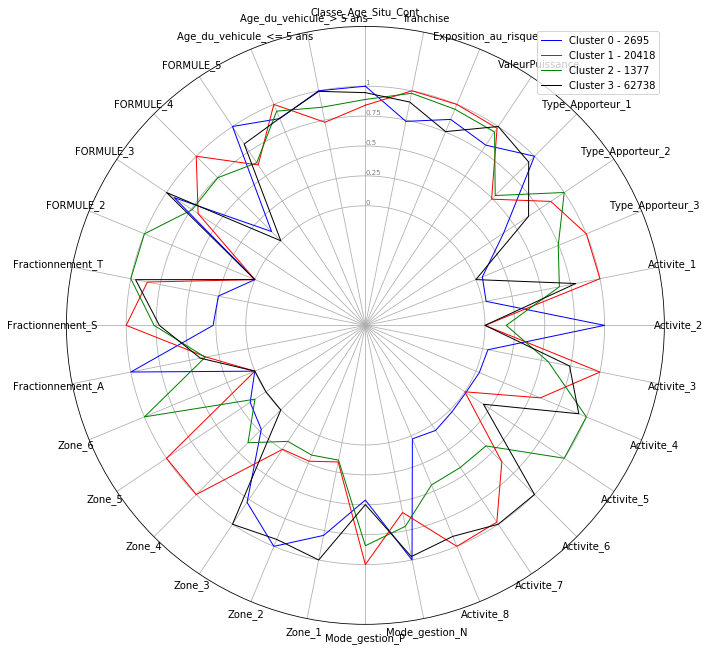

In [185]:
# ------- PART 1: Create background
from math import pi

#df = data_group.drop("cluster", axis=1)
df =(data_group)/(data_group.max())
categories=list(df)
N = 32
 
fig = plt.figure(figsize=(11,11))
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.25,0.5,0.75,1], ["0","0.25","0.5","0.75","1"], color="grey", size=7)
plt.ylim(-1,1.5)

colors = ['b', 'r', 'g', 'black']

for i in range(len(df)):
    
    values=df.loc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {i} - {count[i]}",color=colors[i])
    #ax.fill(angles, values, color=colors[i], alpha=0.05)
plt.legend(loc="best")

On remarque que les clusters on des tailles très différentes (cf légende) mais que les plus petits clusters contiennent tout de même plus de 1000 profils.
On observé également que les variables catégorielles sont très significatives. Plusieurs d'entre elles sont en moyenne (donc pour tous les profils) nulles pour certains clusters. Ainsi, dans le cluster 1 (en rouge), on ne retrouve que les zones 1, 5 et 6. Dans le cluster 0 (en bleu), on ne trouve que des profiles exerçant l'activité 3. A l'inverse, l'exposition au risque, et la puissance du véhicule sont en moyenne quasi-similaire dans tous les clusters.